# Bank Customer Churn Prediction (Machine Learning Project)

## Project brief
**Customers churn prediction:**

Bank dataset
If you select this dataset, the task is to implement, describe and present (binary) regression/classification models of your choice to predict which customers will churn (i.e.,
leave the bank). The goal is to develop (binary) regression/classification models using
any number of the variables provided, which describe customers’ features, to predict their
churn. The dataset will be provided on the QM+ module page

## Notebook structure
1. Setup and data loading  
2. Exploratory Data Analysis (EDA)  
3. Data preprocessing (encoding, split, standardisation)  
4. Model 1 — Logistic Regression  
5. Threshold selection (default, recall-optimised, ROC/Youden) + evaluation  
6. Model 2 — k-Nearest Neighbours
8. Scikit-learn verification and Random Forest
9. Final Comparison and summary of findings


## 1. Setup

Import required libraries and load the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from IPython.display import display
import plotly.io as pio

In [2]:
df = pd.read_csv('Bank.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


## 2.1 Target variable: churn distribution

We start by checking the class balance of the target variable (`churn`).

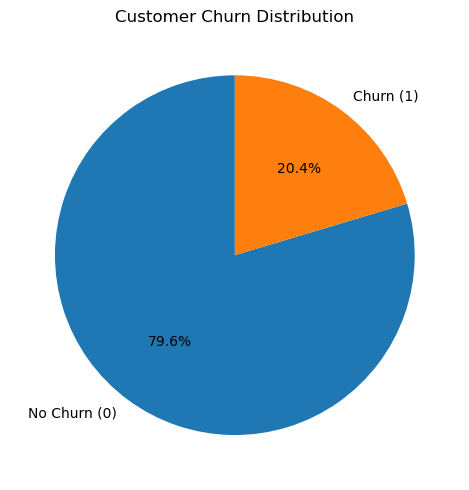

In [3]:
# Count churn values
churn_counts = df['churn'].value_counts()

# Pie chart
plt.figure(figsize=(5,5))
plt.pie(
    churn_counts,
    labels=['No Churn (0)', 'Churn (1)'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Customer Churn Distribution')
plt.tight_layout()
plt.show()


The target variable is moderately **imbalanced**, with about 20% churners and 80% non-churners. As a result, **accuracy** alone can be misleading, since predicting non-churn for all customers would already yield 80% accuracy. Therefore, **confusion matrices** are also used to evaluate model performance.

## 2.2 Customer demographics

Univariate distributions of key demographic attributes (age, gender, country).

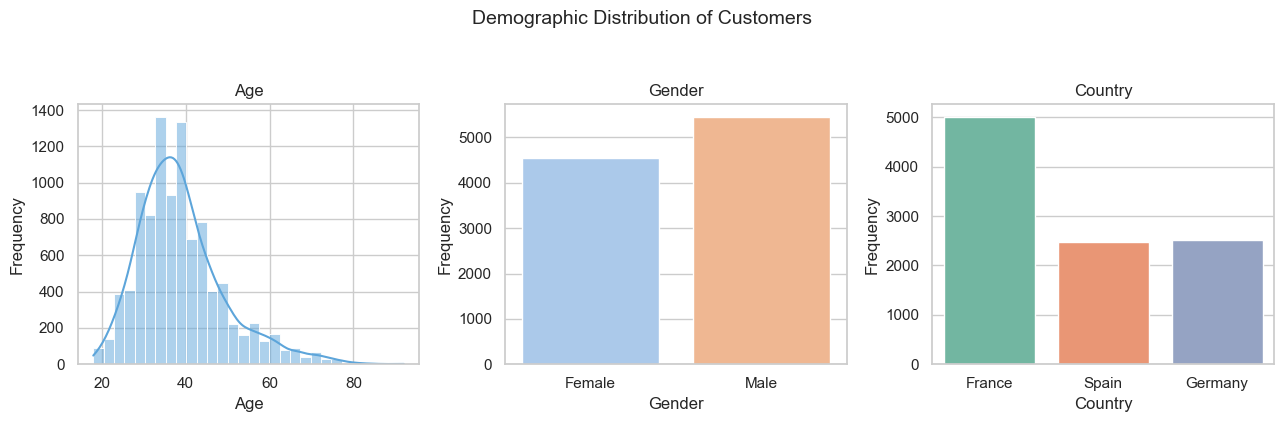

In [4]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Age distribution
sns.histplot(
    df['age'],
    bins=30,
    kde=True,
    color='#5DA5DA',
    ax=axes[0]
)
axes[0].set_title('Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Gender distribution
sns.countplot(
    x='gender',
    hue='gender',
    data=df,
    ax=axes[1],
    palette='pastel',
    legend=False
)
axes[1].set_title('Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Frequency')

# Country distribution
sns.countplot(
    x='country',
    hue='country',
    data=df,
    ax=axes[2],
    palette='Set2',
    legend=False
)
axes[2].set_title('Country')
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Frequency')

fig.suptitle('Demographic Distribution of Customers', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

The customer base is mainly middle-aged (around 30–45 years), slightly male-dominated, and largely concentrated in France, with smaller and similar customer groups from Spain and Germany. These demographic differences may influence churn behaviour and are therefore relevant for the classification analysis.

## 2.3 Financial profile

Distributions of key financial variables (credit score, balance, estimated salary).

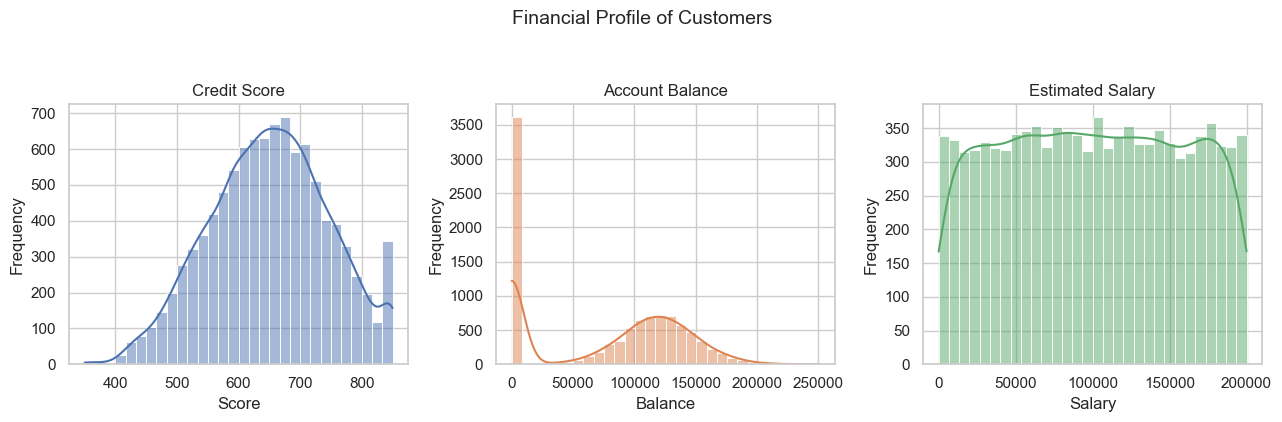

In [5]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Credit score
sns.histplot(
    df['credit_score'],
    bins=30,
    kde=True,
    color='#4C72B0',
    ax=axes[0]
)
axes[0].set_title('Credit Score')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Balance
sns.histplot(
    df['balance'],
    bins=30,
    kde=True,
    color='#DD8452',
    ax=axes[1]
)
axes[1].set_title('Account Balance')
axes[1].set_xlabel('Balance')
axes[1].set_ylabel('Frequency')

# Estimated salary
sns.histplot(
    df['estimated_salary'],
    bins=30,
    kde=True,
    color='#55A868',
    ax=axes[2]
)
axes[2].set_title('Estimated Salary')
axes[2].set_xlabel('Salary')
axes[2].set_ylabel('Frequency')

fig.suptitle('Financial Profile of Customers', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Credit scores are broadly distributed, while account balances are strongly right-skewed, with many customers holding low or zero balances. Estimated salaries are relatively uniform. This suggests that balance and credit score are likely to be more informative for churn prediction than salary.

## 2.4 Customer engagement and relationship indicators

Tenure, number of products, and active membership status.

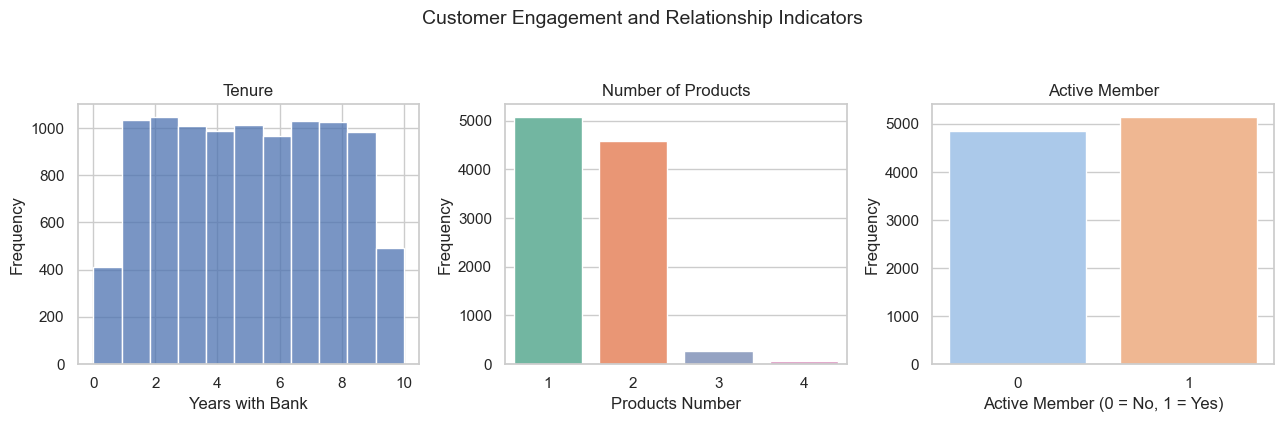

In [6]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Tenure distribution
sns.histplot(
    df['tenure'],
    bins=11,
    kde=False,
    color='#4C72B0',
    ax=axes[0]
)
axes[0].set_title('Tenure')
axes[0].set_xlabel('Years with Bank')
axes[0].set_ylabel('Frequency')

# Products number distribution
sns.countplot(
    x='products_number',
    hue='products_number',
    data=df,
    ax=axes[1],
    palette='Set2',
    legend=False
)
axes[1].set_title('Number of Products')
axes[1].set_xlabel('Products Number')
axes[1].set_ylabel('Frequency')

# Active member distribution
sns.countplot(
    x='active_member',
    hue='active_member',
    data=df,
    ax=axes[2],
    palette='pastel',
    legend=False
)
axes[2].set_title('Active Member')
axes[2].set_xlabel('Active Member (0 = No, 1 = Yes)')
axes[2].set_ylabel('Frequency')

fig.suptitle('Customer Engagement and Relationship Indicators', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Customer tenure is fairly evenly distributed, indicating a mix of new and long-standing clients. Most customers hold one or two products, while only a small fraction hold more. Although the active member variable is balanced in terms of counts, it reflects differences in customer engagement, which may result in different churn rates between active and inactive customers and makes it a potentially important predictor.

## 2.5 Churn rate by key predictors

We examine how churn rate changes across selected features to motivate modelling choices.

Churn analysis focuses on behavioural, financial, and key demographic features—particularly active membership status, number of products, account balance, and age—as these variables are most directly linked to customer engagement and exit behaviour.

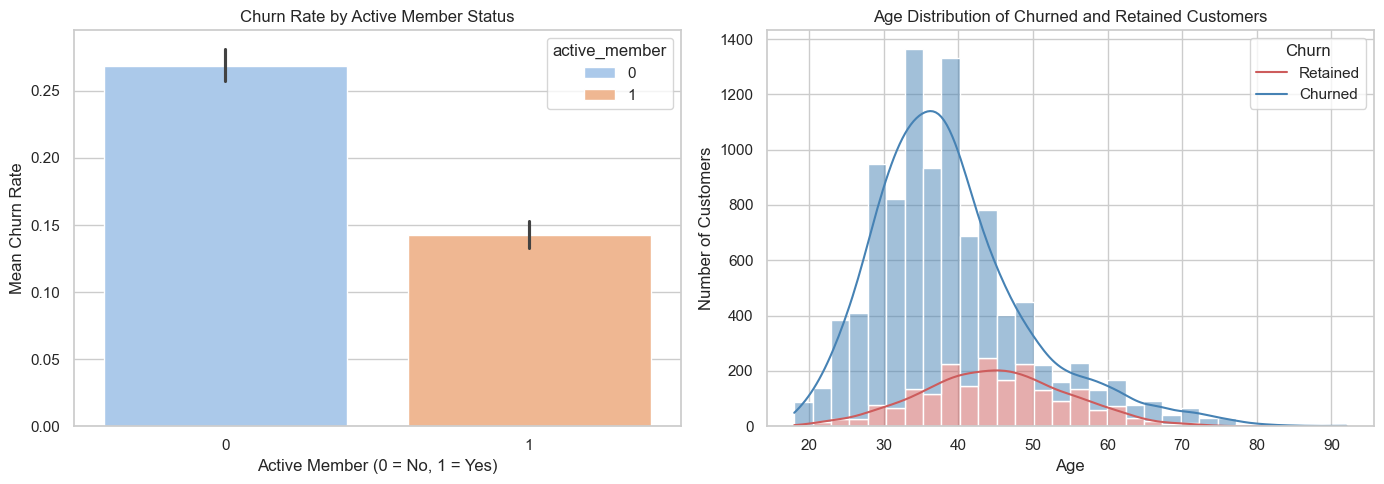

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Active member vs churn (mean churn rate)
sns.barplot(
    x='active_member',
    y='churn',
    hue='active_member',
    data=df,
    ax=axes[0],
    palette='pastel'
)

axes[0].set_title('Churn Rate by Active Member Status')
axes[0].set_xlabel('Active Member (0 = No, 1 = Yes)')
axes[0].set_ylabel('Mean Churn Rate')


# Plot 2: Age distribution by churn
sns.histplot(
    data=df,
    x='age',
    hue='churn',
    bins=30,
    kde=True,
    stat='count',
    multiple='stack',
    ax=axes[1],
    palette={0: 'steelblue', 1: 'indianred'}
)

axes[1].set_title('Age Distribution of Churned and Retained Customers')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Number of Customers')
axes[1].legend(title='Churn', labels=['Retained', 'Churned'])

plt.tight_layout()
plt.show()

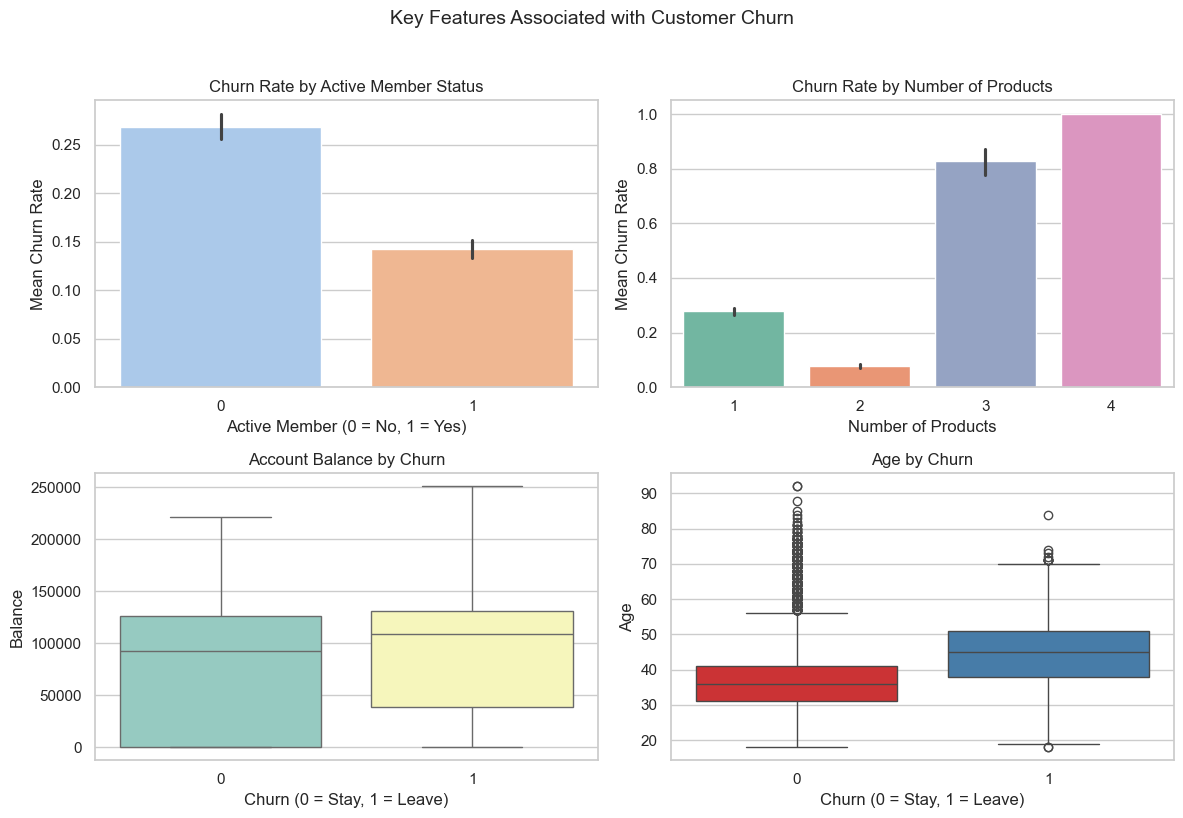

In [8]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Active member vs churn
sns.barplot(
    x='active_member',
    y='churn',
    hue='active_member',
    data=df,
    ax=axes[0, 0],
    palette='pastel',
    legend=False
)
axes[0, 0].set_title('Churn Rate by Active Member Status')
axes[0, 0].set_xlabel('Active Member (0 = No, 1 = Yes)')
axes[0, 0].set_ylabel('Mean Churn Rate')

# Number of products vs churn
sns.barplot(
    x='products_number',
    y='churn',
    hue='products_number',
    data=df,
    ax=axes[0, 1],
    palette='Set2',
    legend=False
)
axes[0, 1].set_title('Churn Rate by Number of Products')
axes[0, 1].set_xlabel('Number of Products')
axes[0, 1].set_ylabel('Mean Churn Rate')

# Balance vs churn
sns.boxplot(
    x='churn',
    y='balance',
    hue='churn',
    data=df,
    ax=axes[1, 0],
    palette='Set3',
    legend=False
)
axes[1, 0].set_title('Account Balance by Churn')
axes[1, 0].set_xlabel('Churn (0 = Stay, 1 = Leave)')
axes[1, 0].set_ylabel('Balance')

# Age vs churn
sns.boxplot(
    x='churn',
    y='age',
    hue='churn',
    data=df,
    ax=axes[1, 1],
    palette='Set1',
    legend=False
)
axes[1, 1].set_title('Age by Churn')
axes[1, 1].set_xlabel('Churn (0 = Stay, 1 = Leave)')
axes[1, 1].set_ylabel('Age')

fig.suptitle('Key Features Associated with Customer Churn', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Inactive customers exhibit substantially higher churn rates than active members, highlighting engagement as a key driver of retention. Churn rates vary strongly with the number of products: customers holding one or two products churn less, while those with three or more products show very high churn, suggesting potential dissatisfaction or complexity effects. Customers who churn generally have lower account balances, indicating weaker financial attachment to the bank. Churners also tend to be slightly older on average, implying that age has a moderate influence on churn behaviour.

## 2.6 Correlation analysis

Correlation heatmap to check linear associations and potential multicollinearity.

In [9]:
# removeing the id
df = df.drop(columns=["customer_id"])

# Encode binary categorical variable: gender
df['gender']=df['gender'].map({
    'Female': 0, 'Male': 1})

# One-hot encode country (drop first to avoid redundancy)
df = pd.get_dummies(df, columns=["country"], drop_first=True)

# Check result
df.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


In [10]:
features = [
    'credit_score',
    'age',
    'tenure',
    'balance',
    'products_number',
    'active_member',
    'estimated_salary',
    'gender',
    'country_Germany',
    'country_Spain',
     'churn'
    
]
corr_matrix = df[features].corr()

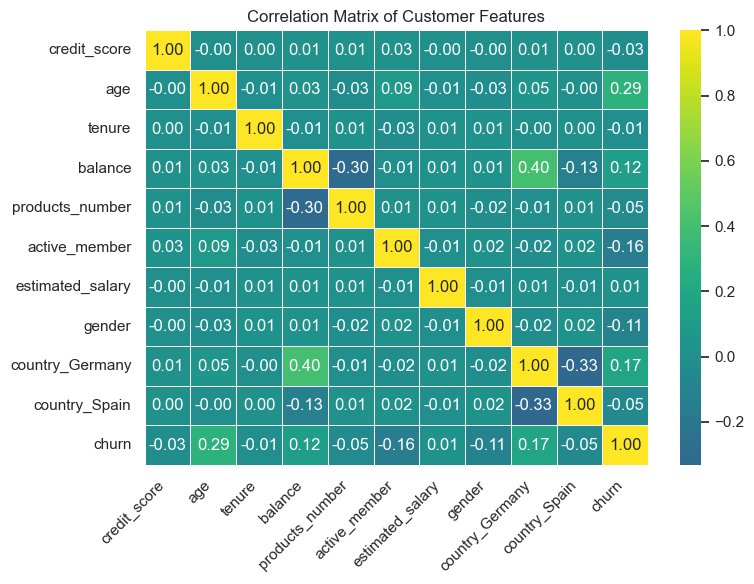

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    center=0,
    linewidths=0.5
)

plt.title('Correlation Matrix of Customer Features')
plt.xticks(rotation=45, ha='right')  

plt.tight_layout()
plt.savefig("C:/Users/USER/Desktop/correlation matrix of customer", dpi=300, bbox_inches="tight")

plt.show()

The correlation analysis indicates that no single feature is strongly linearly correlated with churn, suggesting that churn behaviour is driven by multiple factors rather than a single dominant variable. Age shows the strongest positive association with churn (≈ 0.29), implying that older customers are more likely to leave the bank. Active membership is moderately negatively correlated with churn (≈ −0.16), indicating that more engaged customers tend to be retained. Balance and country indicators show weaker correlations, while estimated salary and credit score exhibit near-zero correlation with churn. Overall, the results support the use of multivariate classification models, as churn cannot be explained by any single feature in isolation.

## 3. Data preprocessing

Prepare the data for modelling: remove identifiers, encode categorical features, split into train/test, then standardise continuous variables.

### 3.1 Stratified train/test split (80/20)

Split the data while preserving the churn / non-churn ratio in both sets.

In [12]:
# Separate features and target 
X = df.drop(columns=['churn']).to_numpy()
y = df['churn'].to_numpy()

# Set seed for reproducibility
np.random.seed(0)

# Get indices for each class
idx_churn = np.where(y == 1)[0]
idx_no_churn = np.where(y == 0)[0]

# Shuffle indices within each class
np.random.shuffle(idx_churn)
np.random.shuffle(idx_no_churn)

# Define split sizes (80% train, 20% test)
n_train_churn = int(0.8 * len(idx_churn))
n_train_no_churn = int(0.8 * len(idx_no_churn))

# Split indices by class
train_idx = np.concatenate([
    idx_churn[:n_train_churn],
    idx_no_churn[:n_train_no_churn]
])

test_idx = np.concatenate([
    idx_churn[n_train_churn:],
    idx_no_churn[n_train_no_churn:]
])

# Shuffle final indices
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

# Create train and test sets 
X_train = X[train_idx]
X_test = X[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]


Given the moderate class imbalance in the dataset, stratification is recommended to preserve the original churn proportions in both training and test sets, ensuring reliable model evaluation.

In [13]:
# Indices of continuous features in X
num_idx = [
    0,  # credit_score
    2,  # age
    3,  # tenure
    4,  # balance
    8   # estimated_salary
]

Continuous numerical features were standardised using z-score normalisation, with the mean and standard deviation computed from the training data and applied consistently to both training and test sets.

In [14]:
# Cast numeric columns to float BEFORE computing statistics
X_train_num = X_train[:, num_idx].astype(float)
X_test_num = X_test[:, num_idx].astype(float)

# Compute mean and std from training data
mean = np.mean(X_train_num, axis=0)
std = np.std(X_train_num, axis=0)

# Safety: avoid division by zero
std[std == 0] = 1

# Standardise
X_train[:, num_idx] = (X_train_num - mean) / std
X_test[:, num_idx] = (X_test_num - mean) / std

# Check
print(np.mean(X_train[:, num_idx].astype(float), axis=0))
print(np.std(X_train[:, num_idx].astype(float), axis=0))

[-4.39703281e-16  3.30887822e-16  8.88289456e-18 -3.55315782e-17
  4.97442095e-17]
[1. 1. 1. 1. 1.]


In [15]:
feature_names = df.drop(columns=['churn']).columns.to_list()
for idx in num_idx:
    print(idx, feature_names[idx])

0 credit_score
2 age
3 tenure
4 balance
8 estimated_salary


### 3.2 Cross-validation folds (K=5)

Create folds from the **training set only** to support model selection and hyperparameter tuning.

In [16]:
# Number of folds
K = 5

# Number of training samples
n_train = X_train.shape[0]

# Shuffle indices of the training set
np.random.seed(0)
indices = np.random.permutation(n_train)

# Split indices into K folds
folds = np.array_split(indices, K)

In [17]:
i = 0  # example fold index

# Validation indices
val_idx = folds[i]

# Training indices (all other folds)
train_idx = np.hstack([folds[j] for j in range(K) if j != i])

# Create fold-specific datasets
X_tr = X_train[train_idx]
y_tr = y_train[train_idx]

X_val = X_train[val_idx]
y_val = y_train[val_idx]

## 4. Model 1 — Logistic Regression.

Implement logistic regression with gradient descent and evaluate with 5-fold cross-validation.

In [18]:
# add intercept to our data 
def add_intercept(X):
    ones = np.ones((X.shape[0], 1))
    return np.hstack((ones, X))

# def the Logistic Regression Core Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# pobability of churning
def predict_proba(X, w):
    return sigmoid(X @ w)

# classification
def predict(X, w, threshold=0.5):
    return (predict_proba(X, w) >= threshold).astype(int)

# gradient descent training
def train_logistic_regression(X, y, alpha=0.01, n_iter=3000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)

    for _ in range(n_iter):
        y_hat = sigmoid(X @ w)
        gradient = (1 / n_samples) * (X.T @ (y_hat - y))
        w -= alpha * gradient

    return w

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


### 4.1 Hyperparameter selection (grid search)

Grid search over learning rate (`alpha`) and number of iterations (`n_iter`) using 5-fold cross-validation on the training set.

In [19]:
K = 5

alphas = [0.1, 0.01, 0.001]
n_iters = [1000, 3000, 5000]

results = []

for alpha in alphas:
    for n_iter in n_iters:

        cv_accuracies = []

        for i in range(K):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(K) if j != i])

            # PUT THE CODE HERE (as you already fixed)
            X_tr = X_train[train_idx].astype(float)
            y_tr = y_train[train_idx].astype(int)

            X_val = X_train[val_idx].astype(float)
            y_val = y_train[val_idx].astype(int)

            # Add intercept
            X_tr = add_intercept(X_tr)
            X_val = add_intercept(X_val)

            # Train
            w = train_logistic_regression(X_tr, y_tr, alpha, n_iter)

            # Validate
            y_val_pred = predict(X_val, w)
            acc = accuracy(y_val, y_val_pred)

            cv_accuracies.append(acc)

        mean_acc = np.mean(cv_accuracies)
        std_acc = np.std(cv_accuracies)

        results.append((alpha, n_iter, mean_acc, std_acc))

        print(
            'alpha =', alpha,
            'n_iter =', n_iter,
            'mean CV acc =', mean_acc,
            'std =', std_acc
        )

alpha = 0.1 n_iter = 1000 mean CV acc = 0.8136035803627267 std = 0.00922178893577198
alpha = 0.1 n_iter = 3000 mean CV acc = 0.8137285803627268 std = 0.008766940520229678
alpha = 0.1 n_iter = 5000 mean CV acc = 0.8134785803627267 std = 0.008735976549110487
alpha = 0.01 n_iter = 1000 mean CV acc = 0.7974764696685429 std = 0.008088230194337954
alpha = 0.01 n_iter = 3000 mean CV acc = 0.8093534240150093 std = 0.010767473363635673
alpha = 0.01 n_iter = 5000 mean CV acc = 0.8127285803627269 std = 0.00937270808308349
alpha = 0.001 n_iter = 1000 mean CV acc = 0.7964758442776736 std = 0.006013098432373308
alpha = 0.001 n_iter = 3000 mean CV acc = 0.7962258442776735 std = 0.00617112428138075
alpha = 0.001 n_iter = 5000 mean CV acc = 0.7941006879299563 std = 0.006312641023849869


**Methodology** Logistic regression hyperparameters were selected using a grid search over the learning rate and number of iterations with five-fold cross-validation on the training set. Mean validation accuracy and its standard deviation were used to compare model performance.

**Interpretation and final choice :**
Based on five-fold cross-validation, a learning rate of 0.1 and 3000 gradient descent iterations were selected, as this combination achieved the highest mean validation accuracy with low variability across folds.

### 4.3 Final training and baseline evaluation (threshold = 0.5)

Train the final model on the full training set using the selected hyperparameters, then evaluate on the held-out test set.

In [20]:
# Ensure correct dtypes
X_train_final = X_train.astype(float)
y_train_final = y_train.astype(int)

X_test_final = X_test.astype(float)
y_test_final = y_test.astype(int)

# Add intercept
X_train_final = add_intercept(X_train_final)
X_test_final = add_intercept(X_test_final)

# Train final logistic regression model
alpha = 0.1
n_iter = 3000

w_final = train_logistic_regression(
    X_train_final,
    y_train_final,
    alpha=alpha,
    n_iter=n_iter
)

#### 4.3.1 Feature importance from logistic regression

In [21]:
Y = df.drop(columns=['churn']).columns.tolist()

coefficients = w_final[1:]  # remove intercept

lr_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

lr_importance['Abs Coefficient'] = np.abs(lr_importance['Coefficient'])

lr_importance = (
    lr_importance
    .sort_values('Abs Coefficient', ascending=False)
    .reset_index(drop=True)
)

lr_importance[['Coefficient', 'Abs Coefficient']] = (
    lr_importance[['Coefficient', 'Abs Coefficient']]
    .astype(float)
    .round(4)
)

lr_importance

,Feature,Coefficient,Abs Coefficient
0,active_member,-1.1042,1.1042
1,age,0.7727,0.7727
2,country_Germany,0.7504,0.7504
3,gender,-0.5460,0.5460
4,balance,0.1443,0.1443
5,products_number,-0.1276,0.1276
6,credit_score,-0.0892,0.0892
7,tenure,-0.0514,0.0514
8,country_Spain,-0.0201,0.0201
9,estimated_salary,0.0185,0.0185


The logistic regression coefficients show that active membership is the strongest predictor of churn, with active customers being significantly less likely to leave. Age and country (Germany) are positively associated with churn, indicating higher churn risk among older customers and German clients. Gender also has a noticeable effect, while account balance and number of products have smaller but meaningful influences. In contrast, credit score, tenure, estimated salary, credit card ownership, and Spain residency contribute very little once other variables are accounted for. Overall, engagement and demographic factors dominate churn prediction more than purely financial attributes.

#### 4.3.2 Apply the model to predict the Test Set

In [22]:
y_test_pred = predict(X_test_final, w_final)


In [23]:
test_accuracy = accuracy(y_test_final, y_test_pred)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.8040979510244878


In [24]:
TP = np.sum((y_test_final == 1) & (y_test_pred == 1))
TN = np.sum((y_test_final == 0) & (y_test_pred == 0))
FP = np.sum((y_test_final == 0) & (y_test_pred == 1))
FN = np.sum((y_test_final == 1) & (y_test_pred == 0))

confusion_matrix = np.array([[TN, FP],
                             [FN, TP]])

print('Confusion matrix:')
print(confusion_matrix)

Confusion matrix:
[[1536   57]
 [ 335   73]]


In [25]:
recall_churn = TP / (TP + FN)
print('Recall (churn class):', recall_churn)

Recall (churn class): 0.17892156862745098


## 4.4 Threshold Optimisation for Churn Detection

Because churn is the minority class, different decision thresholds can lead to very different business outcomes.
Below we explore three threshold strategies:

1. **Default (0.5)** — baseline
2. **Recall-optimised threshold** — prioritises catching churners
3. **ROC / Youden's J threshold** — balances TPR and FPR

In [26]:
# Predicted probabilities for churn (training data)
y_train_proba = predict_proba(X_train_final, w_final)

# Define recall computation
def recall_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN) if (TP + FN) > 0 else 0

# Scan thresholds
thresholds = np.linspace(0.05, 0.95, 91)
recalls = []

for t in thresholds:
    y_pred_t = (y_train_proba >= t).astype(int)
    recalls.append(recall_score(y_train_final, y_pred_t))


# Find the optimal threshold (for recall)
recalls = np.array(recalls)

best_idx = np.argmax(recalls)
best_threshold = thresholds[best_idx]
best_recall = recalls[best_idx]

print('Optimal threshold (training-based):', best_threshold)
print('Recall at optimal threshold:', best_recall)

Optimal threshold (training-based): 0.05
Recall at optimal threshold: 0.9779005524861878


In [27]:
# Training predictions at optimised threshold
y_train_pred_opt = (y_train_proba >= best_threshold).astype(int)

# Training accuracy
train_accuracy_opt = accuracy(y_train_final, y_train_pred_opt)

print('Training accuracy (optimised threshold):', train_accuracy_opt)

Training accuracy (optimised threshold): 0.3131641455181898


### 4.5 Apply Recall-Optimised Threshold to the Test Set
Use the **Optimised Threshold (0.05)** for the test

In [28]:
# Predicted probabilities for churn (test data)
y_test_proba = predict_proba(X_test_final, w_final)

# Predict churn on test data using optimised threshold
y_test_pred_opt = (y_test_proba >= best_threshold).astype(int)

# Confusion matrix (test set)
TP = np.sum((y_test_final == 1) & (y_test_pred_opt == 1))
TN = np.sum((y_test_final == 0) & (y_test_pred_opt == 0))
FP = np.sum((y_test_final == 0) & (y_test_pred_opt == 1))
FN = np.sum((y_test_final == 1) & (y_test_pred_opt == 0))

confusion_matrix = np.array([
    [TN, FP],
    [FN, TP]
])

print('Confusion matrix:')
print(confusion_matrix)

Confusion matrix:
[[ 233 1360]
 [  10  398]]


In [29]:
# Recall (churn class)
recall_churn = TP / (TP + FN) if (TP + FN) > 0 else 0
print('Recall (churn class):', recall_churn)

Recall (churn class): 0.9754901960784313


In [30]:
# Test accuracy
test_accuracy_opt = accuracy(y_test_final, y_test_pred_opt)

print('Test accuracy (optimised threshold):', test_accuracy_opt)

Test accuracy (optimised threshold): 0.3153423288355822


Applying the optimised classification threshold increased recall for churners at the cost of a modest reduction in overall accuracy, highlighting the trade-off between sensitivity and accuracy in imbalanced classification problems.

In [31]:

# --- Default threshold (0.5) ---
y_train_pred_default = (y_train_proba >= 0.5).astype(int)
y_test_pred_default = (y_test_proba >= 0.5).astype(int)

train_acc_default = accuracy(y_train_final, y_train_pred_default)
test_acc_default = accuracy(y_test_final, y_test_pred_default)
recall_default = recall_score(y_test_final, y_test_pred_default)

# --- Optimised threshold ---
y_train_pred_opt = (y_train_proba >= best_threshold).astype(int)
y_test_pred_opt = (y_test_proba >= best_threshold).astype(int)

train_acc_opt = accuracy(y_train_final, y_train_pred_opt)
test_acc_opt = accuracy(y_test_final, y_test_pred_opt)
recall_opt = recall_score(y_test_final, y_test_pred_opt)

comparison_table = pd.DataFrame({
    'Method': [
        'Default threshold',
        'Recall-optimised threshold',
    ],
    'Threshold value': [
        0.5,
        best_threshold,
    ],
    'Train accuracy': [
        train_acc_default,
        train_acc_opt,
    ],
    'Test accuracy': [
        test_acc_default,
        test_acc_opt,
        
    ],
    'Recall (churn)': [
        recall_default,
        recall_opt,
        
    ],

})

# --- Create comparison table ---
comparison_table = comparison_table.round(4)

print('\nComparison of Logistic Regression Thresholds')
print('=' * 55)
print(comparison_table.to_string(index=False))
print('=' * 55)


Comparison of Logistic Regression Thresholds
                    Method  Threshold value  Train accuracy  Test accuracy  Recall (churn)
         Default threshold             0.50          0.8134         0.8041          0.1789
Recall-optimised threshold             0.05          0.3132         0.3153          0.9755


By optimising the classification threshold to maximise recall, the model is able to identify almost all customers who are at risk of churning. This improvement in churn detection comes at the expense of misclassifying many non-churners as churners, which significantly reduces overall accuracy. Such behaviour is expected in imbalanced classification problems, as increasing sensitivity to the minority class inevitably increases the number of false positives.


## 4.6 ROC Curve and Youden’s J Threshold (Training-Based)

In this section, the ROC curve is constructed using **training-set predicted probabilities**, and an operating threshold is selected using **Youden’s J statistic**:
J = TPR − FPR

In [32]:
# Predicted probabilities on TRAINING data
y_train_proba = predict_proba(X_train_final, w_final)

thresholds = np.linspace(0, 1, 200)
TPR = []
FPR = []

for t in thresholds:
    y_pred = (y_train_proba >= t).astype(int)

    TP = np.sum((y_train_final == 1) & (y_pred == 1))
    FN = np.sum((y_train_final == 1) & (y_pred == 0))
    FP = np.sum((y_train_final == 0) & (y_pred == 1))
    TN = np.sum((y_train_final == 0) & (y_pred == 0))

    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

    TPR.append(tpr)
    FPR.append(fpr)

TPR = np.array(TPR)
FPR = np.array(FPR)

### 4.6.1 Youden’s J Selection

We compute the Youden score across thresholds and select the threshold that maximises \(J\).

In [33]:
J = TPR - FPR
best_idx = np.argmax(J)
youden_threshold = thresholds[best_idx]

print('Youden optimal threshold (training-based):', youden_threshold)
print('TPR at threshold:', TPR[best_idx])
print('FPR at threshold:', FPR[best_idx])

Youden optimal threshold (training-based): 0.17587939698492464
TPR at threshold: 0.7655003069367711
FPR at threshold: 0.358712715855573


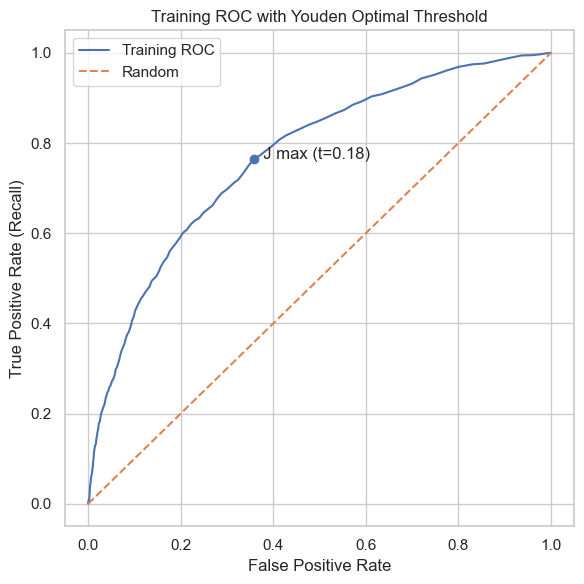

In [34]:
plt.figure(figsize=(6, 6))
plt.plot(FPR, TPR, label='Training ROC')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')

plt.scatter(FPR[best_idx], TPR[best_idx])
plt.text(FPR[best_idx], TPR[best_idx],
         f'  J max (t={youden_threshold:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Training ROC with Youden Optimal Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
y_test_pred_youden = (y_test_proba >= youden_threshold).astype(int)


In [36]:
TP = np.sum((y_test_final == 1) & (y_test_pred_youden == 1))
TN = np.sum((y_test_final == 0) & (y_test_pred_youden == 0))
FP = np.sum((y_test_final == 0) & (y_test_pred_youden == 1))
FN = np.sum((y_test_final == 1) & (y_test_pred_youden == 0))

confusion_matrix = np.array([
    [TN, FP],
    [FN, TP]
])

print('Confusion matrix (Youden threshold):')
print(confusion_matrix)

Confusion matrix (Youden threshold):
[[1030  563]
 [ 114  294]]


In [37]:
recall_youden = TP / (TP + FN) if (TP + FN) > 0 else 0
print('Recall (churn, Youden threshold):', recall_youden)

Recall (churn, Youden threshold): 0.7205882352941176


In [38]:
accuracy_youden = accuracy(y_test_final, y_test_pred_youden)
print('Test accuracy (Youden threshold):', accuracy_youden)

Test accuracy (Youden threshold): 0.6616691654172914


## 4.7 Comparison of Threshold Strategies (Test Set)

We compare the three threshold strategies on the **test set** using:
- **Accuracy**
- **Recall (churn)**
- **Precision (churn)**

The table summarises the trade-off between catching churners and avoiding false alarms.

In [39]:
# Precision function (churn class)
def precision_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    return TP / (TP + FP) if (TP + FP) > 0 else 0


In [40]:
# --- 1. Default threshold (0.5) ---
y_test_pred_default = (y_test_proba >= 0.5).astype(int)
acc_default = accuracy(y_test_final, y_test_pred_default)
recall_default = recall_score(y_test_final, y_test_pred_default)
precision_default = precision_score(y_test_final, y_test_pred_default)

# --- 2. Recall-optimised threshold ---
y_test_pred_recall = (y_test_proba >= best_threshold).astype(int)
acc_recall = accuracy(y_test_final, y_test_pred_recall)
recall_recall = recall_score(y_test_final, y_test_pred_recall)
precision_recall = precision_score(y_test_final, y_test_pred_recall)

# --- 3. Youden threshold ---
y_test_pred_youden = (y_test_proba >= youden_threshold).astype(int)
acc_youden = accuracy(y_test_final, y_test_pred_youden)
recall_youden = recall_score(y_test_final, y_test_pred_youden)
precision_youden = precision_score(y_test_final, y_test_pred_youden)

comparison_test = pd.DataFrame({
    'Method': [
        'Default threshold',
        'Recall-optimised threshold',
        'Youden (ROC-based) threshold'
    ],
    'Threshold value': [
        0.5,
        best_threshold,
        youden_threshold
    ],
    'Test accuracy': [
        acc_default,
        acc_recall,
        acc_youden
    ],
    'Recall (churn)': [
        recall_default,
        recall_recall,
        recall_youden
    ],
    'Precision (churn)': [
        precision_default,
        precision_recall,
        precision_youden
    ]
})

comparison_test = comparison_test.round(4)

print('\nComparison of Threshold Strategies (Test Set)')
print('=' * 70)
print(comparison_test.to_string(index=False))
print('=' * 70)


Comparison of Threshold Strategies (Test Set)
                      Method  Threshold value  Test accuracy  Recall (churn)  Precision (churn)
           Default threshold           0.5000         0.8041          0.1789             0.5615
  Recall-optimised threshold           0.0500         0.3153          0.9755             0.2264
Youden (ROC-based) threshold           0.1759         0.6617          0.7206             0.3431


The comparison shows that threshold selection strongly influences model behaviour, with the default threshold favouring accuracy, recall optimisation prioritising churn detection, and the Youden criterion providing a balanced operating point.

**Findings and Results**

The default classification threshold (0.5) yields the highest test accuracy (0.8041) and precision (0.5615), but it identifies only a small fraction of churners, with recall limited to 0.1789. This indicates that, while overall predictions are largely correct, the model fails to capture most customers who actually churn.

Lowering the threshold to optimise recall substantially increases churn detection, achieving a recall of 0.9755. However, this comes with a pronounced drop in test accuracy (0.3153) and precision (0.2264), reflecting a large number of non-churners being incorrectly classified as churners.

The ROC-based Youden threshold provides a more balanced outcome, with recall increasing to 0.7206 while maintaining moderate test accuracy (0.6617) and precision (0.3431). This suggests that the Youden threshold represents a practical compromise between maximising churn detection and preserving overall predictive performance.

## 5. Model 2 —  K-Nearest Neighbours (k-NN) Model

In this section we implement k-NN and select \(k\) using the **same 5 folds** as logistic regression for a fair comparison.

### 5.1 k-NN Core Functions (NumPy)

We implement:
- Euclidean distance
- Majority vote prediction
- Batch prediction for a validation/test set

In [41]:
# Euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# k-NN prediction for a single point
def knn_predict_single(x, X_train, y_train, k):
    distances = np.array([euclidean_distance(x, x_train) for x_train in X_train])
    k_idx = np.argsort(distances)[:k]
    k_labels = y_train[k_idx]
    return np.bincount(k_labels).argmax()

# k-NN prediction for multiple points
def knn_predict(X_test, X_train, y_train, k):
    return np.array([knn_predict_single(x, X_train, y_train, k) for x in X_test])

### 5.2 Hyperparameter Selection: 5-Fold Cross-Validation for k

We evaluate the number of neighbour values:
k {3, 5, 7, 9, 15}
and record mean accuracy, variability across folds, and mean recall for churn.

Runtime 15minutes

In [42]:
k_values = [3, 5, 7, 9, 15]
results = []

for k in k_values:
    cv_accuracies = []
    cv_recalls = []

    for i in range(K):
        val_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(K) if j != i])

        X_tr = X_train_final[train_idx]
        y_tr = y_train_final[train_idx]

        X_val = X_train_final[val_idx]
        y_val = y_train_final[val_idx]

        y_val_pred = knn_predict(X_val, X_tr, y_tr, k)

        acc = np.mean(y_val == y_val_pred)

        TP = np.sum((y_val == 1) & (y_val_pred == 1))
        FN = np.sum((y_val == 1) & (y_val_pred == 0))
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        cv_accuracies.append(acc)
        cv_recalls.append(recall)

    results.append((
        k,
        np.mean(cv_accuracies),
        np.std(cv_accuracies),
        np.mean(cv_recalls)
    ))

    print(
        'k =', k,
        '| mean acc =', round(np.mean(cv_accuracies), 4),
        '| std acc =', round(np.std(cv_accuracies), 4),
        '| mean recall =', round(np.mean(cv_recalls), 4)
    )

k = 3 | mean acc = 0.82 | std acc = 0.0054 | mean recall = 0.3917
k = 5 | mean acc = 0.8315 | std acc = 0.0097 | mean recall = 0.3758
k = 7 | mean acc = 0.8339 | std acc = 0.0096 | mean recall = 0.3514
k = 9 | mean acc = 0.8375 | std acc = 0.0104 | mean recall = 0.3367
k = 15 | mean acc = 0.8392 | std acc = 0.0099 | mean recall = 0.3158


The value of k was selected based on five-fold cross-validation by jointly considering mean accuracy, variability across folds, and recall for the churn class. Although k = 3 achieved the highest recall, it also yielded lower accuracy and is more sensitive to noise due to its reliance on very local neighbourhoods. The value k = 5 was therefore selected as it provides a better balance between high accuracy, reasonably high recall, and improved stability, making it a more robust choice for generalisation.

The standard k-NN classifier using majority voting is equivalent to k-NN probability classification with a threshold of 0.5, since both predict the positive class when more than half of the nearest neighbours belong to that class.

### 5.3 Final k-NN Evaluation on the Test Set

After selecting the best \(k\), evaluate on the held-out test set:
- Accuracy
- Recall (churn)
- Precision (churn)
- Confusion matrix

In [43]:
# Final k-NN model
k_final = 5

# Predict on test set using full training set
y_test_pred_knn = knn_predict(X_test_final, X_train_final, y_train_final, k_final)

# Metrics (reuse your existing functions)
test_acc_knn = accuracy(y_test_final, y_test_pred_knn)
test_recall_knn = recall_score(y_test_final, y_test_pred_knn)
test_precision_knn = precision_score(y_test_final, y_test_pred_knn)

print('k-NN (k=5) test accuracy:', test_acc_knn)
print('k-NN (k=5) test recall (churn):', test_recall_knn)
print('k-NN (k=5) test precision (churn):', test_precision_knn)

k-NN (k=5) test accuracy: 0.8300849575212393
k-NN (k=5) test recall (churn): 0.35294117647058826
k-NN (k=5) test precision (churn): 0.6545454545454545


In [44]:
# Confusion matrix (same format as before)
TP = np.sum((y_test_final == 1) & (y_test_pred_knn == 1))
TN = np.sum((y_test_final == 0) & (y_test_pred_knn == 0))
FP = np.sum((y_test_final == 0) & (y_test_pred_knn == 1))
FN = np.sum((y_test_final == 1) & (y_test_pred_knn == 0))

confusion_matrix_knn = np.array([[TN, FP],
                                 [FN, TP]])

print('Confusion matrix (k-NN, k=5):')
print(confusion_matrix_knn)

Confusion matrix (k-NN, k=5):
[[1517   76]
 [ 264  144]]


### 5.4 Youden-Optimised k-NN (Probability Model + Youden Threshold)

This section converts k-NN outputs into **probabilities** and selects a decision threshold using **Youden’s J** (training-based), then evaluates the resulting classifier on the test set.

#### 5.4.1 Probability version of k-NN

To apply ROC/Youden thresholding, k-NN must output a probability of churn. Here, the probability is the **fraction of churners among the k nearest neighbours**.

In [45]:
# k-NN probability

def knn_predict_proba(X_test, X_train, y_train, k):
    probs = []

    for x in X_test:
        distances = np.sqrt(np.sum((X_train - x) ** 2, axis=1))
        nn_idx = np.argsort(distances)[:k]
        probs.append(np.mean(y_train[nn_idx]))  # P(churn)

    return np.array(probs)


In [46]:
k_opt = 5  # your chosen k
y_train_proba_knn = knn_predict_proba(X_train_final, X_train_final, y_train_final, k_opt)


In [47]:
thresholds = np.linspace(0.01, 0.99, 99)

best_J = -np.inf
youden_threshold_knn = 0

for t in thresholds:
    y_pred = (y_train_proba_knn >= t).astype(int)

    TP = np.sum((y_train_final == 1) & (y_pred == 1))
    TN = np.sum((y_train_final == 0) & (y_pred == 0))
    FP = np.sum((y_train_final == 0) & (y_pred == 1))
    FN = np.sum((y_train_final == 1) & (y_pred == 0))

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    J = TPR - FPR

    if J > best_J:
        best_J = J
        youden_threshold_knn = t

print('Optimal Youden threshold (KNN):', youden_threshold_knn)

Optimal Youden threshold (KNN): 0.21000000000000002


In [48]:
y_test_proba_knn = knn_predict_proba(X_test_final, X_train_final, y_train_final, k_opt)
y_test_pred_knn_youden = (y_test_proba_knn >= youden_threshold_knn).astype(int)

acc_knn_youden = accuracy(y_test_final, y_test_pred_knn_youden)
recall_knn_youden = recall_score(y_test_final, y_test_pred_knn_youden)

print('KNN Youden-optimised accuracy:', acc_knn_youden)
print('KNN Youden-optimised recall:', recall_knn_youden)

KNN Youden-optimised accuracy: 0.7976011994002998
KNN Youden-optimised recall: 0.5612745098039216


## 6. scikit-learn Implementations (Validation)

To validate the Numpy model implementations, the same models are re-run using scikit-learn and compared using the same metrics and thresholds.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

### 6.1 Logistic Regression Base Model (scikit-learn)

Train a baseline logistic regression model and evaluate using the default threshold of 0.5.

In [50]:
# Logistic Regression model
lr_sklearn = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=3000
)

# Train
lr_sklearn.fit(X_train_final, y_train_final)


LogisticRegression(max_iter=3000)

In [51]:
# Predicted probabilities
y_test_proba = lr_sklearn.predict_proba(X_test_final)[:, 1]

# Default predictions
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test_final, y_test_pred)
recall = recall_score(y_test_final, y_test_pred)
precision = precision_score(y_test_final, y_test_pred)

cm = confusion_matrix(y_test_final, y_test_pred)

print('Accuracy:', acc)
print('Recall (churn):', recall)
print('Precision (churn):', precision)
print('Confusion matrix:\n', cm)

Accuracy: 0.8040979510244878
Recall (churn): 0.17647058823529413
Precision (churn): 0.5625
Confusion matrix:
 [[1537   56]
 [ 336   72]]


### 6.2 Logistic Regression with Youden Threshold (scikit-learn)

In [52]:
lr = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000
)

lr.fit(X_train_final, y_train_final)

# predicted probabilities (TEST set)
y_test_proba = lr.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_final, y_test_proba)


In [53]:
# Compute ROC curve 
youden_J = tpr - fpr
best_idx = np.argmax(youden_J)

youden_threshold = thresholds[best_idx]

print('Youden optimal threshold:', youden_threshold)

y_test_pred_youden = (y_test_proba >= youden_threshold).astype(int)


Youden optimal threshold: 0.22706508270636558


In [54]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

acc_youden = accuracy_score(y_test_final, y_test_pred_youden)
recall_youden = recall_score(y_test_final, y_test_pred_youden)
precision_youden = precision_score(y_test_final, y_test_pred_youden)
cm_youden = confusion_matrix(y_test_final, y_test_pred_youden)

print('Accuracy:', acc_youden)
print('Recall (churn):', recall_youden)
print('Precision (churn):', precision_youden)
print('Confusion matrix:\n', cm_youden)

Accuracy: 0.7341329335332334
Recall (churn): 0.6323529411764706
Precision (churn): 0.403125
Confusion matrix:
 [[1211  382]
 [ 150  258]]


### 6.3 k-NN Base Model (scikit-learn)

In [55]:
# k-NN model (k chosen from CV)
k_final = 5

knn_sklearn = KNeighborsClassifier(
    n_neighbors=k_final,
    weights='uniform',
    metric='euclidean'
)

# "Train" (store training data)
knn_sklearn.fit(X_train_final, y_train_final)

KNeighborsClassifier(metric='euclidean')

In [56]:
# Predicted probabilities (churn)
y_test_proba_knn = knn_sklearn.predict_proba(X_test_final)[:, 1]

# Default threshold predictions
y_test_pred_knn = (y_test_proba_knn >= 0.5).astype(int)

# Metrics
acc_knn = accuracy_score(y_test_final, y_test_pred_knn)
recall_knn = recall_score(y_test_final, y_test_pred_knn)
precision_knn = precision_score(y_test_final, y_test_pred_knn)
cm_knn = confusion_matrix(y_test_final, y_test_pred_knn)

print('k-NN Accuracy:', acc_knn)
print('k-NN Recall (churn):', recall_knn)
print('k-NN Precision (churn):', precision_knn)
print('Confusion matrix:\n', cm_knn)

k-NN Accuracy: 0.8300849575212393
k-NN Recall (churn): 0.35294117647058826
k-NN Precision (churn): 0.6545454545454545
Confusion matrix:
 [[1517   76]
 [ 264  144]]


### 6.4 k-NN with Youden Threshold (scikit-learn)

In [57]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test_final, y_test_proba_knn)

# Youden's J statistic
youden_J = tpr - fpr
best_idx = np.argmax(youden_J)
youden_threshold_knn = thresholds[best_idx]

print('Youden optimal threshold (k-NN):', youden_threshold_knn)

Youden optimal threshold (k-NN): 0.4


In [58]:
# Predictions at Youden threshold
y_test_pred_knn_youden = (y_test_proba_knn >= youden_threshold_knn).astype(int)

acc_knn_youden = accuracy_score(y_test_final, y_test_pred_knn_youden)
recall_knn_youden = recall_score(y_test_final, y_test_pred_knn_youden)
precision_knn_youden = precision_score(y_test_final, y_test_pred_knn_youden)
cm_knn_youden = confusion_matrix(y_test_final, y_test_pred_knn_youden)

print('k-NN Youden Accuracy:', acc_knn_youden)
print('k-NN Youden Recall:', recall_knn_youden)
print('k-NN Youden Precision:', precision_knn_youden)
print('Confusion matrix (Youden):\n', cm_knn_youden)

k-NN Youden Accuracy: 0.7976011994002998
k-NN Youden Recall: 0.5612745098039216
k-NN Youden Precision: 0.5032967032967033
Confusion matrix (Youden):
 [[1367  226]
 [ 179  229]]


In [59]:
k_values = [3, 5, 7, 9, 15]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for k in k_values:
    accs = []
    recalls = []

    for train_idx, val_idx in cv.split(X_train_final, y_train_final):
        X_tr, X_val = X_train_final[train_idx], X_train_final[val_idx]
        y_tr, y_val = y_train_final[train_idx], y_train_final[val_idx]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_tr, y_tr)

        y_val_pred = knn.predict(X_val)

        accs.append(accuracy_score(y_val, y_val_pred))
        recalls.append(recall_score(y_val, y_val_pred))

    print(
        'k =', k,
        '| mean acc =', round(np.mean(accs), 4),
        '| mean recall =', round(np.mean(recalls), 4)
    )

k = 3 | mean acc = 0.8195 | mean recall = 0.388
k = 5 | mean acc = 0.8325 | mean recall = 0.3757
k = 7 | mean acc = 0.838 | mean recall = 0.3622
k = 9 | mean acc = 0.8374 | mean recall = 0.3468
k = 15 | mean acc = 0.8382 | mean recall = 0.3161


### 6.5 Random Forest Baseline (scikit-learn, threshold = 0.5)

In [60]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=0,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train_final, y_train_final)

# Predict probabilities
y_test_proba_rf = rf.predict_proba(X_test_final)[:, 1]

# Default threshold
y_test_pred_rf = (y_test_proba_rf >= 0.5).astype(int)

# Metrics
acc_rf = accuracy_score(y_test_final, y_test_pred_rf)
recall_rf = recall_score(y_test_final, y_test_pred_rf)
precision_rf = precision_score(y_test_final, y_test_pred_rf)
cm_rf = confusion_matrix(y_test_final, y_test_pred_rf)

print('Random Forest – Default threshold (0.5)')
print('Accuracy:', acc_rf)
print('Recall:', recall_rf)
print('Precision:', precision_rf)
print('Confusion matrix:\n', cm_rf)

Random Forest – Default threshold (0.5)
Accuracy: 0.8660669665167416
Recall: 0.4411764705882353
Precision: 0.8181818181818182
Confusion matrix:
 [[1553   40]
 [ 228  180]]


### 6.6 Random Forest with Youden Threshold (training-based)

In [61]:
# Training probabilities
y_train_proba_rf = rf.predict_proba(X_train_final)[:, 1]

# ROC + Youden
fpr, tpr, thresholds = roc_curve(y_train_final, y_train_proba_rf)
youden_J = tpr - fpr
best_idx = np.argmax(youden_J)
youden_threshold_rf = thresholds[best_idx]

print('Youden threshold (RF):', youden_threshold_rf)

Youden threshold (RF): 0.57


In [62]:
# Apply optimised threshold
y_test_pred_rf_youden = (y_test_proba_rf >= youden_threshold_rf).astype(int)

acc_rf_youden = accuracy_score(y_test_final, y_test_pred_rf_youden)
recall_rf_youden = recall_score(y_test_final, y_test_pred_rf_youden)
precision_rf_youden = precision_score(y_test_final, y_test_pred_rf_youden)
cm_rf_youden = confusion_matrix(y_test_final, y_test_pred_rf_youden)

print('\nRandom Forest – Youden threshold')
print('Accuracy:', acc_rf_youden)
print('Recall:', recall_rf_youden)
print('Precision:', precision_rf_youden)
print('Confusion matrix:\n', cm_rf_youden)


Random Forest – Youden threshold
Accuracy: 0.8570714642678661
Recall: 0.36519607843137253
Precision: 0.8465909090909091
Confusion matrix:
 [[1566   27]
 [ 259  149]]


In [63]:
import pandas as pd

rf_results = pd.DataFrame({
    'Method': ['Default threshold', 'Youden threshold'],
    'Threshold': [0.5, youden_threshold_rf],
    'Test accuracy': [acc_rf, acc_rf_youden],
    'Recall (churn)': [recall_rf, recall_rf_youden],
    'Precision (churn)': [precision_rf, precision_rf_youden]
}).round(4)

print('\nRandom Forest – Threshold Comparison')
print('=' * 65)
print(rf_results.to_string(index=False))
print('=' * 65)


Random Forest – Threshold Comparison
           Method  Threshold  Test accuracy  Recall (churn)  Precision (churn)
Default threshold       0.50         0.8661          0.4412             0.8182
 Youden threshold       0.57         0.8571          0.3652             0.8466


## 8. Final Comparison and Summary

This section consolidates the final test-set results across models (logistic regression, k-NN, and random forest) under comparable evaluation settings.

ROC AUC (TEST) | Logistic: 0.7528 | k-NN (k=5): 0.7663 | RF: 0.8561


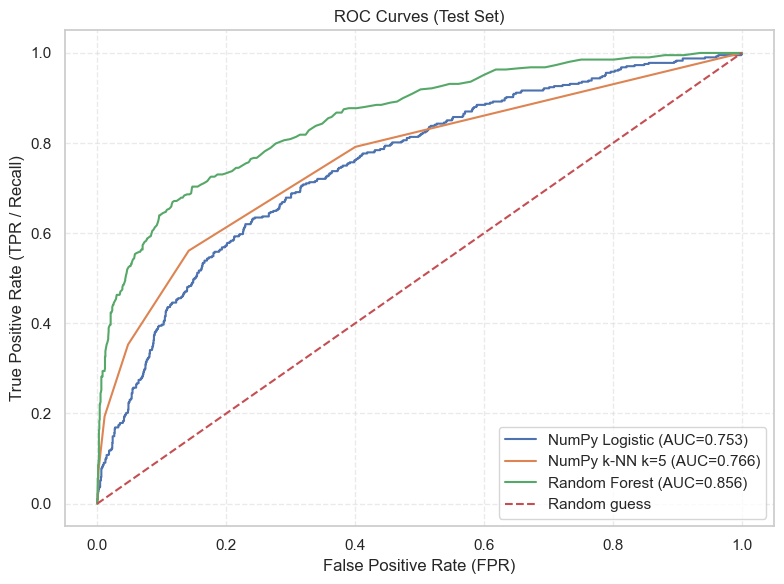

In [64]:
def roc_curve_numpy(y_true, y_score):
    y_true = np.asarray(y_true, dtype=int).ravel()
    y_score = np.asarray(y_score, dtype=float).ravel()

    # Sort by score descending
    order = np.argsort(-y_score)
    y_true = y_true[order]
    y_score = y_score[order]

    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    # Cumulative TP/FP as threshold moves
    tp = np.cumsum(y_true == 1)
    fp = np.cumsum(y_true == 0)

    # Keep only points where the score changes (unique thresholds)
    idx = np.r_[np.where(np.diff(y_score))[0], y_true.size - 1]

    tpr = tp[idx] / P if P else np.zeros(idx.size, dtype=float)
    fpr = fp[idx] / N if N else np.zeros(idx.size, dtype=float)

    # Add (0,0) start point
    return np.r_[0.0, fpr], np.r_[0.0, tpr]

def auc_trapz(fpr, tpr):
    return float(np.trapezoid(tpr, fpr))
    
# ----------------------------
# Scores on TEST set (use your existing models)
# ----------------------------
y_true = np.asarray(y_test_final, dtype=int).ravel()

y_score_lr = predict_proba(X_test_final, w_final)                 # NumPy Logistic
y_score_knn = knn_predict_proba(X_test_final, X_train_final, y_train_final, k_final)  # NumPy k-NN
y_score_rf = rf.predict_proba(X_test_final)[:, 1]                 # sklearn Random Forest

# ----------------------------
# ROC + AUC
# ----------------------------
fpr_lr, tpr_lr = roc_curve_numpy(y_true, y_score_lr)
fpr_knn, tpr_knn = roc_curve_numpy(y_true, y_score_knn)
fpr_rf, tpr_rf = roc_curve_numpy(y_true, y_score_rf)

auc_lr = auc_trapz(fpr_lr, tpr_lr)
auc_knn = auc_trapz(fpr_knn, tpr_knn)
auc_rf = auc_trapz(fpr_rf, tpr_rf)

print(f'ROC AUC (TEST) | Logistic: {auc_lr:.4f} | k-NN (k={k_final}): {auc_knn:.4f} | RF: {auc_rf:.4f}')

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'NumPy Logistic (AUC={auc_lr:.3f})')
plt.plot(fpr_knn, tpr_knn, label=f'NumPy k-NN k={k_final} (AUC={auc_knn:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('ROC Curves (Test Set)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:

comparison_table = pd.DataFrame([
    {
        'Model': 'Logistic Regression (standard)',
        'Accuracy (TEST)': acc_default,
        'Precision (TEST)': precision_default,
        'Recall (TEST)': recall_default
    },
    {
        'Model': 'Logistic Regression (Youden)',
        'Accuracy (TEST)': acc_youden,
        'Precision (TEST)': precision_youden,
        'Recall (TEST)': recall_youden
    },
    {
        'Model': 'k-NN (standard)',
        'Accuracy (TEST)': acc_knn,
        'Precision (TEST)': precision_knn,
        'Recall (TEST)': recall_knn
    },
    {
        'Model': 'k-NN (Youden)',
        'Accuracy (TEST)': acc_knn_youden,
        'Precision (TEST)': precision_knn_youden,
        'Recall (TEST)': recall_knn_youden
    },
    {
        'Model': 'Random Forest (standard)',
        'Accuracy (TEST)': acc_rf,
        'Precision (TEST)': precision_rf,
        'Recall (TEST)': recall_rf
    },
    {
        'Model': 'Random Forest (Youden)',
        'Accuracy (TEST)': acc_rf_youden,
        'Precision (TEST)': precision_rf_youden,
        'Recall (TEST)': recall_rf_youden
    }
])

comparison_table[['Accuracy (TEST)', 'Precision (TEST)', 'Recall (TEST)']] = (
    comparison_table[['Accuracy (TEST)', 'Precision (TEST)', 'Recall (TEST)']].astype(float).round(4)
)

comparison_table

,Model,Accuracy (TEST),Precision (TEST),Recall (TEST)
0,Logistic Regression (standard),0.8041,0.5615,0.1789
1,Logistic Regression (Youden),0.7341,0.4031,0.6324
2,k-NN (standard),0.8301,0.6545,0.3529
3,k-NN (Youden),0.7976,0.5033,0.5613
4,Random Forest (standard),0.8661,0.8182,0.4412
5,Random Forest (Youden),0.8571,0.8466,0.3652
